In [23]:
import numpy as np
import os
import random 
import unittest
import matplotlib.pyplot as plt

In [34]:
initial_population_size = 20
chromosome_length = 12
mutation_probability = 0.01
iterations = 500

In [35]:
def generate_random_number():
    return random.random()

In [36]:
def fitness_function(decoded):
    x = decoded / 20.0
    fval = ((x - 150.0) / 25.0) ** 3 - (x - 150.0) + 300.0
    return fval * fval

In [37]:
def compute_fitness(chromosome):
    mult = 1
    val = 0
    for x in chromosome:
        val = val + mult * x
        mult = mult * 2

    return (val, fitness_function(val))

In [38]:
class Chromosome(object):

    def __init__(self, ch):
        self.chromosome = ch

        (decoded, fitness) = compute_fitness(ch)
        
        self.fitness = fitness
        self.decoded = decoded
    
    def __str__(self):
        return f'Chromosome:{self.chromosome}, fitness:{self.fitness}, decoded:{self.decoded}'

    def __repr__(self):
        return self.__str__()

In [39]:
def generate_random_binary_chromosome(ch_le):
    return (np.random.rand(1, ch_le) * 2).astype(int)[0]

In [40]:
def generate_random_population(count, ch_le):
    res = []
    for _ in range(0, count):
        ch = generate_random_binary_chromosome(ch_le)

        chromosome = Chromosome(ch)
        
        res.append(chromosome)

    return res

In [41]:
def mutate_chromosome(chromosome, mutation_probability):
    mutated = False
    for ix in range(0, len(chromosome.chromosome)):
        if generate_random_number() <= mutation_probability:
            chromosome.chromosome[ix] = 1 - chromosome.chromosome[ix]
            mutated = True

    (decoded, fitness) = compute_fitness(chromosome.chromosome)
    
    chromosome.fitness = fitness
    chromosome.decoded = decoded

    return chromosome

In [42]:
def crossover_chromosome_pair_with_cutpoint(cha, chb, cut_point):
    ch_len = len(cha.chromosome)
    chc = np.concatenate((cha.chromosome[0:cut_point], chb.chromosome[cut_point: ch_len]))
    chd = np.concatenate((chb.chromosome[0:cut_point], cha.chromosome[cut_point: ch_len]))

    ch1 = Chromosome(chc)
    ch2 = Chromosome(chd)

    return (ch1, ch2)

In [43]:
def crossover_chromosome_pair(cha, chb):
    ch_len = len(cha.chromosome)
    cut_point = int(random.random() * (ch_len + 1))

    return crossover_chromosome_pair_with_cutpoint(cha, chb, cut_point)

In [44]:
def compute_summary_fitness(population):
    summary_fitness = 0.0

    for ch in population:
        summary_fitness += ch.fitness

    return summary_fitness

In [45]:
def select_chromosome(old_population, summary_fitness):
    selector_value = summary_fitness * generate_random_number()
    sum = 0.0
    for ch in old_population:
        sum += ch.fitness
        if selector_value <= sum:
            return ch

    raise ValueError("WTF")

In [46]:
def generate_new_population(old_population, new_population_size, mutation_probability):
    new_population = []
    summary_fitness = compute_summary_fitness(old_population)

    for ix in range(0, new_population_size // 2):
        selector_value = summary_fitness * generate_random_number()
        sum = 0.0

        cha = select_chromosome(old_population, summary_fitness)
        chb = select_chromosome(old_population, summary_fitness)

        (chc, chd) = crossover_chromosome_pair(cha, chb)
        chc = mutate_chromosome(chc, mutation_probability)
        chd = mutate_chromosome(chd, mutation_probability)

        new_population.append(chc)
        new_population.append(chd)

    return new_population

In [47]:
def find_best_chromosome(population):
    res = population[0]
    
    for ch in population:
        if ch.fitness > res.fitness:
            res = ch

    return res

In [48]:
def find_worst_chromosome(population):
    res = population[0]
    
    for ch in population:
        if ch.fitness < res.fitness:
            res = ch

    return res

In [63]:
def main_loop(iterations, initial_population_size, chromosome_length, mutation_probability, log_best):
    population = generate_random_population(initial_population_size, chromosome_length)

    best_fitness = []
    worst_fitness = []
    best_history = []
    
    for ix in range(0, iterations):
        new_population = generate_new_population(population, initial_population_size, mutation_probability)
        population = new_population
        best = find_best_chromosome(population)
        worst = find_worst_chromosome(population)
        best_fitness.append(best.fitness)
        worst_fitness.append(worst.fitness)
        best_history.append(best)
        if log_best:
            print(best)

    result = (find_best_chromosome(population), population, best_fitness, worst_fitness, best_history)

    return result

In [64]:
result = main_loop(100, initial_population_size, chromosome_length, mutation_probability, False)

In [65]:
(best, population, best_fitness, worst_fitness, best_history) = result

In [59]:
xx = np.linspace(0, 2**chromosome_length, 2**chromosome_length)
yy = [fitness_function(x) for x in xx]

In [66]:
bx = [ch.decoded for ch in best_history]
by = [ch.fitness for ch in best_history]

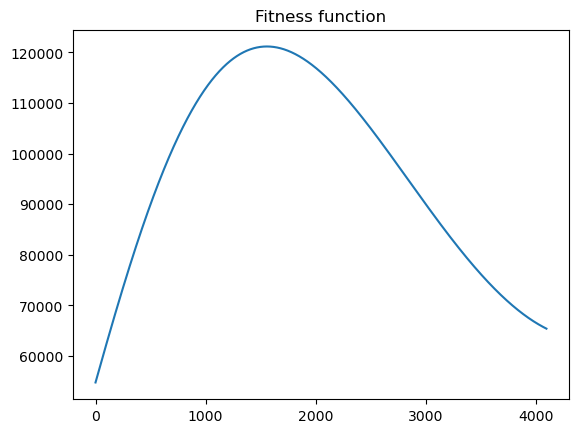

In [67]:
plt.plot(xx, yy)
plt.title('Fitness function')
plt.show()

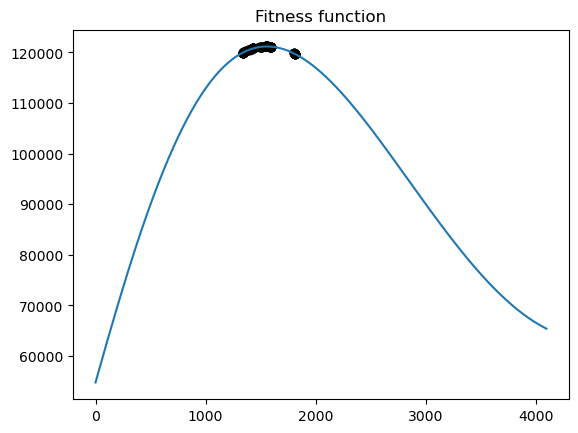

In [71]:
plt.plot(xx, yy)
plt.title('Fitness function')
plt.scatter(bx, by, marker='o', c='black')
plt.show()

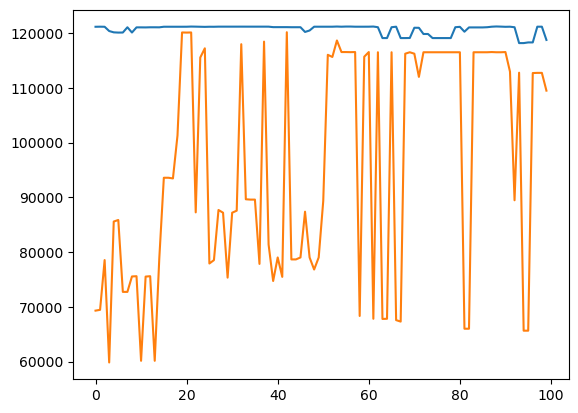

In [52]:
plt.plot(best_fitness)
plt.plot(worst_fitness)
plt.show()

In [53]:
class TestCrossover(unittest.TestCase):
    
    def test1(self):
        cha = Chromosome([0,0,0,1,1])
        chb = Chromosome([1,1,1,0,0])
        (chc, chd) = crossover_chromosome_pair_with_cutpoint(cha, chb, 3)
        self.assertTrue(np.array_equal(chc.chromosome, [0, 0, 0, 0, 0]))
        self.assertTrue(np.array_equal(chd.chromosome, [1, 1, 1, 1, 1]))

    def test2(self):
        cha = Chromosome([0,0,0,1,1])
        chb = Chromosome([1,1,1,0,0])
        (chc, chd) = crossover_chromosome_pair_with_cutpoint(cha, chb, 1)
        self.assertTrue(np.array_equal(chc.chromosome, [0, 1, 1, 0, 0]))
        self.assertTrue(np.array_equal(chd.chromosome, [1, 0, 0, 1, 1]))

    def test3(self):
        cha = Chromosome([0,0,0,0,1])
        chb = Chromosome([1,0,0,0,0])
        (chc, chd) = crossover_chromosome_pair_with_cutpoint(cha, chb, 0)
        self.assertTrue(np.array_equal(chc.chromosome, [1, 0, 0, 0, 0]))
        self.assertTrue(np.array_equal(chd.chromosome, [0, 0, 0, 0, 1]))

    def test4(self):
        cha = Chromosome([1,1,1,1,1])
        chb = Chromosome([0,0,0,0,0])
        (chc, chd) = crossover_chromosome_pair_with_cutpoint(cha, chb, 0)
        self.assertTrue(np.array_equal(chc.chromosome, [0, 0, 0, 0, 0]))
        self.assertTrue(np.array_equal(chd.chromosome, [1, 1, 1, 1, 1]))

In [54]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

....
----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK
